In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import sys

sys.path.append('/kaggle/input/haarpsi')

In [3]:
import pickle
from haarPsi import *
from PIL import Image
import cv2
import pywt
from tqdm import tqdm
from numba import njit
from sklearn.metrics import *
from sklearn.cluster import spectral_clustering
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def noisy2(image, std_percent=10.0):
    """
    Добавляет гауссовский шум на изображение.

    Args:
        image: ndarray. Исходное изображение.
        std_percent: float. Процент стандартного отклонения нормального распределения.

    Returns:
        ndarray. Зашумленное изображение.
    """
    # Нормализуем значения интенсивности пикселей к диапазону [0, 1].
    image = image.astype(np.float32) / 255.0

    # Генерируем матрицу шума с нулевым средним и стандартным отклонением,
    # определяемым заданным процентом от интенсивности каждого пикселя.
    noise = np.random.normal(loc=0, scale=image * std_percent / 100.0)

    # Добавляем шум к изображению.
    noisy_image = image + noise

    # Обрезаем значения интенсивности пикселей до диапазона [0, 1].
    noisy_image = np.clip(noisy_image, 0.0, 1.0)

    # Масштабируем значения интенсивности пикселей обратно в диапазон [0, 255] типа uint8.
    noisy_image = (noisy_image * 255.0).astype(np.uint8)

    return noisy_image

In [5]:
def aa(path):
    data = pd.DataFrame(columns=['image', 'label', 'number'])
    imlist = [(os.path.join(path, f), int(f[: f.find('_')]), int(f[f.find('_') + 1 : f.find('.')])) 
              for f in os.listdir(path) if f.endswith('.jpg')]
    for i, f in tqdm(enumerate(imlist)):
        im = Image.open(f[0])
        im = np.array(im).flatten()
        data.at[i, 'image'] = im.flatten()
        data.at[i, 'label'] = f[2]
        data.at[i, 'number'] = f[1]
                      
    return data

In [6]:
train = aa('/kaggle/input/the-orl-database-for-training-and-testing')

410it [00:01, 249.51it/s]


In [7]:
train.sort_values('label', inplace=True)

In [8]:
train.reset_index(inplace=True, drop=True)

In [9]:
train['label'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41], dtype=object)

In [30]:
train['image'].loc[train['label'] == 7]

60    [48, 64, 55, 58, 60, 55, 65, 62, 59, 58, 71, 6...
61    [37, 44, 41, 44, 44, 47, 41, 45, 48, 49, 48, 4...
62    [40, 46, 43, 43, 44, 43, 46, 47, 45, 48, 50, 4...
63    [50, 64, 60, 58, 64, 62, 61, 62, 60, 64, 66, 6...
64    [38, 47, 42, 41, 44, 42, 43, 44, 45, 45, 45, 4...
65    [36, 45, 42, 43, 44, 42, 45, 43, 46, 44, 45, 4...
66    [40, 45, 45, 46, 44, 43, 48, 43, 46, 46, 46, 4...
67    [36, 45, 42, 47, 43, 46, 47, 46, 46, 47, 48, 5...
68    [42, 46, 44, 42, 46, 46, 51, 45, 48, 47, 47, 4...
69    [50, 60, 55, 61, 57, 56, 56, 60, 63, 57, 61, 6...
Name: image, dtype: object

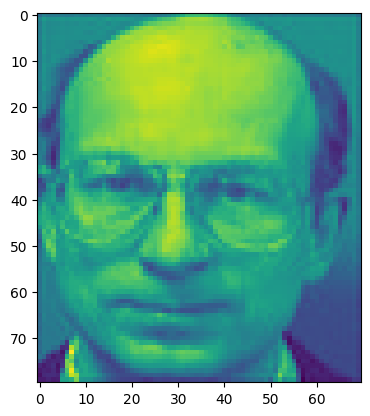

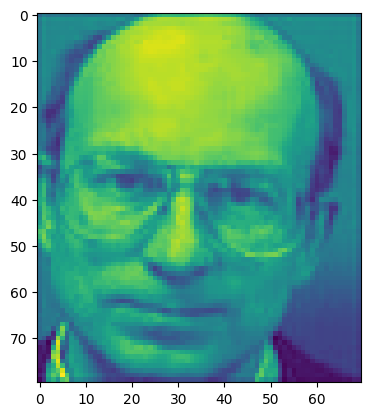

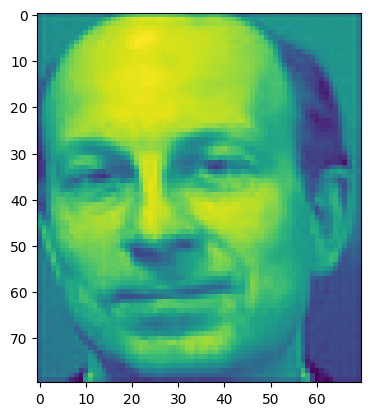

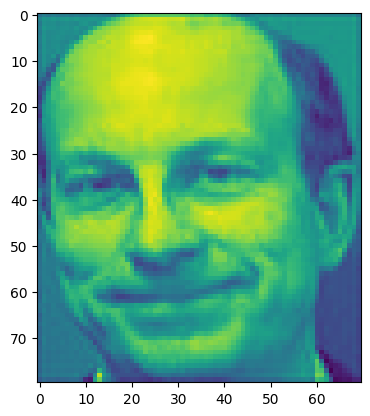

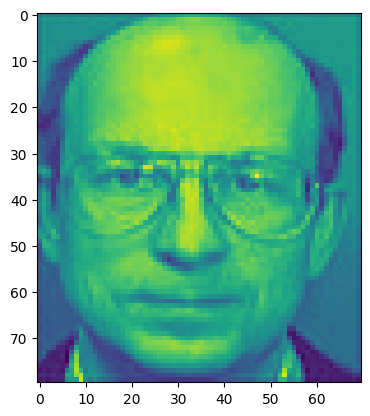

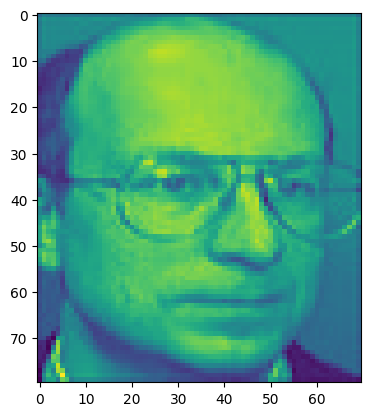

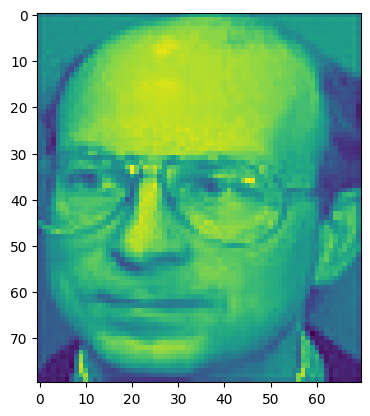

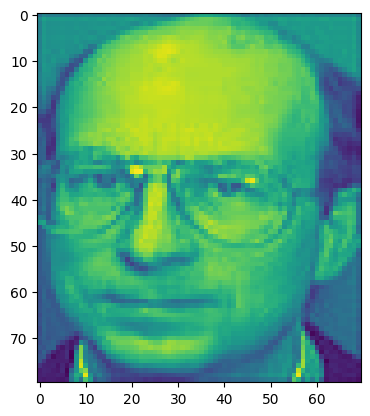

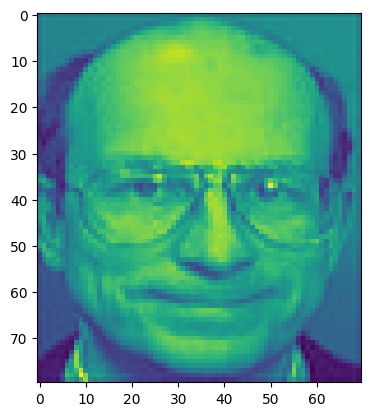

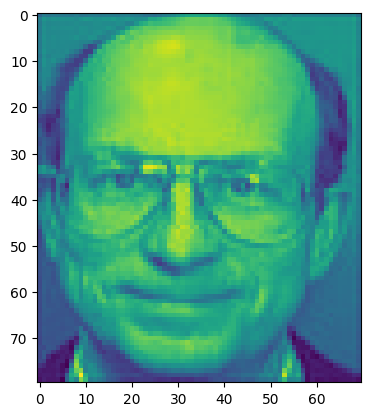

In [37]:
for i in range(121, 131):
    plt.imshow(np.resize(list(train['image'].loc[(train['label'] == 13) & (train['number'] == i)]), (80, 70)))
    plt.show()

In [10]:
def sim_matrix_haar_psi(data, size):
    
    sim_matrix = np.zeros([size, size])
    
    for i in tqdm(range(size)):
        
        for j in range(i, size):

            res = haar_psi(data[i], data[j])[0]
            
            sim_matrix[i][j], sim_matrix[j][i] = res, res
            
    return sim_matrix

In [11]:
def resize_for_haar_psi(data):
    
    return [np.resize(img, (80, 70)) for img in data]

In [12]:
def get_signal(img1, img2):
    
    widths = [18]

    cwtmatr1 = signal.cwt(img1, signal.ricker, widths)
    cwtmatr2 = signal.cwt(img2, signal.ricker, widths)
    
    return cwtmatr1, cwtmatr2

In [13]:
@njit(parallel=True)
def cw_ssim(cwtmatr1, cwtmatr2, k=0.01):
    
    c1c2_conj = np.multiply(cwtmatr1, np.conjugate(cwtmatr2))
    
    c1c2_sum = np.sum(c1c2_conj, axis=0)
    
    num_ssim = 2 * np.abs(c1c2_sum) + k
    
    c1_2 = np.square(np.abs(cwtmatr1))
    c2_2 = np.square(np.abs(cwtmatr2))
    
    den_ssim = np.sum(c1_2, axis=0) + np.sum(c2_2, axis=0) + k

    ssim_map = num_ssim / den_ssim

    # Average the per pixel results
    index = np.average(ssim_map)
    
    return index

In [14]:
def sim_matrix_cw(data, size):
    
    sim_m = np.zeros([size, size])
    
    for i in tqdm(range(size+1)):
        
        for j in range(i, size):
            
            cwtmatr1, cwtmatr2 = get_signal(data[i], data[j])
            
            res = cw_ssim(cwtmatr1, cwtmatr2)
            
            sim_m[i][j], sim_m[j][i] = res, res
            
            
    return sim_m

In [15]:
def haar_signal(img1, img2):
    
    coef1, freq1 = pywt.dwt2(img1.reshape(80, 70), 'haar')
    coef2, freq2 = pywt.dwt2(img2.reshape(80, 70), 'haar')
    
    return coef1, coef2

In [16]:
def matrix_cw_haar(data, size):
    sim_m = np.zeros([size, size])
    
    for i in tqdm(range(size+1)):
        
        for j in range(i, size):
            
            cwtmatr1, cwtmatr2 = haar_signal(data[i], data[j])
            
            res = cw_ssim(cwtmatr1, cwtmatr2)
            
            sim_m[i][j], sim_m[j][i] = res, res
            
            
    return sim_m

In [16]:
def check_noise_no_rot(data, label, noise_perc, name_label=None):
    y_cw_ricker = []
    y_cw_haar = []
    y_haar_psi = []
    
    sample = data.loc[data.label == label]
    sample.sort_values('number', inplace=True)
    sample.reset_index(drop=True, inplace=True)
    x = [num for num in range(10)]

    for i in range(len(sample)):
        image = sample.image[i]
        noisy_image = noisy2(np.resize(sample.image[i], (80, 70)), noise_perc)
        
        cw_ricker1, cw_ricker2 = get_signal(image.flatten(), noisy_image.flatten())
        y_cw_ricker.append(cw_ssim(cw_ricker1, cw_ricker2))

        cw_haar1, cw_haar2 = haar_signal(image, noisy_image)
        y_cw_haar.append(cw_ssim(cw_haar1, cw_haar2))

        y_haar_psi.append(haar_psi(np.resize(image, (80, 70)), 
                                    np.resize(noisy_image, (80, 70)))[0])
        
    #plt.imshow(np.resize(sample['image'][0], (80, 70)))
    #plt.show()
    #plt.imshow(np.resize(noisy2(np.resize(sample.image[0], (80, 70)), noise_perc), (80, 70)))
    #plt.show()
    
    #if name_label:
    #    plt.title(f'Класс №{label}: {name_label}')
    #else:
    #    plt.title(f'Класс №{label}')
        
    #plt.plot(x, y_cw_ricker, label='CW-SSIM with Ricker')
    #plt.plot(x, y_haar_psi, label='HaarPsi')
    #plt.plot(x, y_cw_haar, label='CW-SSIM with Haar')
    #plt.xlabel('Градус поворота')
    #plt.ylabel('Значение метрики близости')
    #plt.legend()
    #plt.show()
    
    return y_cw_ricker, y_cw_haar, y_haar_psi

In [17]:
cw_r = []
cw_h = []
h_p = []

for j in range(1, 41):
    r, h, p = check_noise_no_rot(train, j, 10)
    cw_r.append(r)
    cw_h.append(h)
    h_p.append(p)

/tmp/ipykernel_34/1583871210.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values('number', inplace=True)
/tmp/ipykernel_34/1583871210.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values('number', inplace=True)


In [49]:
mean_r = np.zeros(10)
mean_h = np.zeros(10)
mean_p = np.zeros(10)

for i in range(len(cw_r)):
    mean_r += np.array(cw_r[i])
    mean_h += np.array(cw_h[i])
    mean_p += np.array(h_p[i])

In [50]:
mean_r = mean_r / len(cw_r)
mean_h = mean_h / len(cw_r)
mean_p = mean_p / len(cw_r)

In [52]:
x = [i for i in range(1, 11)]

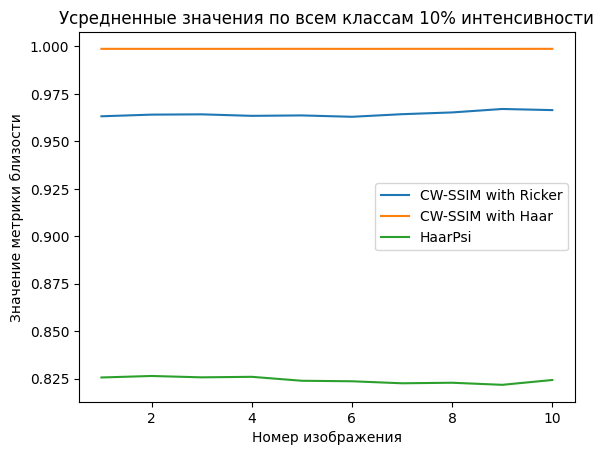

In [53]:
plt.plot(x, mean_r, label='CW-SSIM with Ricker')
plt.plot(x, mean_h, label='CW-SSIM with Haar')
plt.plot(x, mean_p, label='HaarPsi')
plt.xlabel('Номер изображения')
plt.ylabel('Значение метрики близости')
plt.title('Усредненные значения по всем классам 10% интенсивности')
plt.legend()
plt.show()

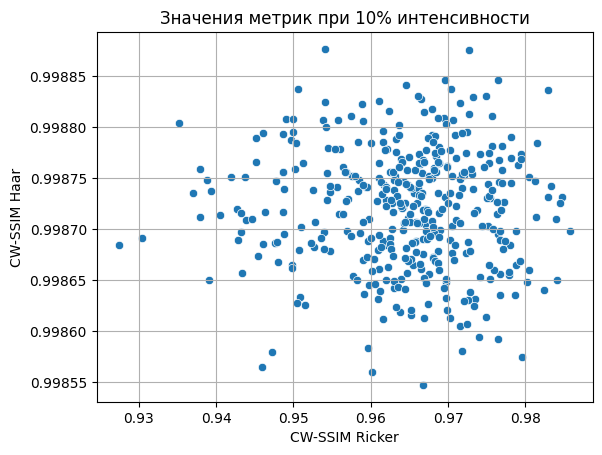

In [57]:
sns.scatterplot(x=np.array(cw_r).flatten(), y=np.array(cw_h).flatten())
plt.title('Значения метрик при 10% интенсивности')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('CW-SSIM Haar')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

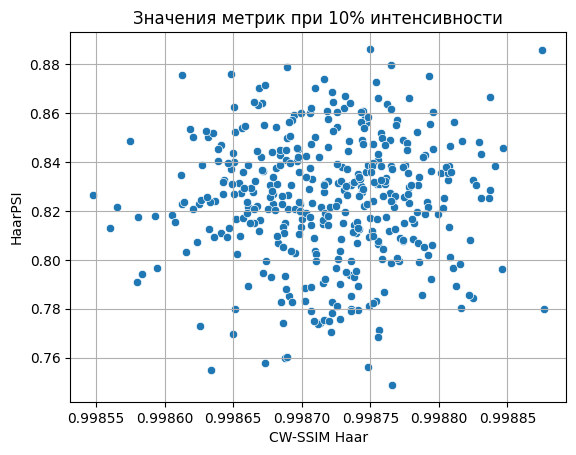

In [58]:
sns.scatterplot(x=np.array(cw_h).flatten(), y=np.array(h_p).flatten())
plt.title('Значения метрик при 10% интенсивности')
plt.xlabel('CW-SSIM Haar')
plt.ylabel('HaarPSI')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

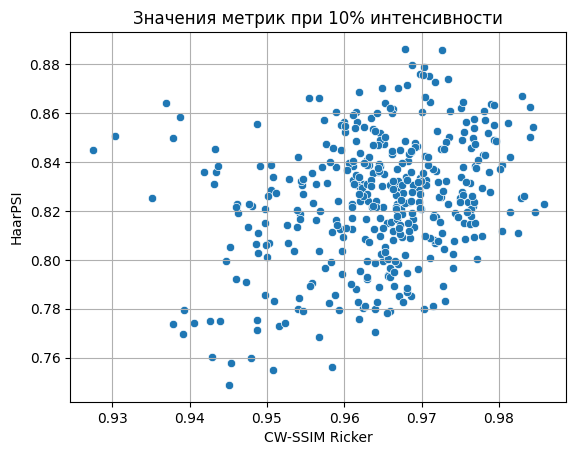

In [59]:
sns.scatterplot(x=np.array(cw_r).flatten(), y=np.array(h_p).flatten())
plt.title('Значения метрик при 10% интенсивности')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('HaarPSI')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

In [18]:
def check_image_no_noise(data, label, label_name=None):
    y_cw_ricker = []
    y_cw_haar = []
    y_haar_psi = []
    
    sample = data.loc[data.label == label]
    sample.sort_values('number', inplace=True)
    sample.reset_index(drop=True, inplace=True)
    
    x = [num for num in range(10)]
    
    image0 = sample.image[0]

    for i in range(len(sample)):
        image = sample.image[i]
        
        cw_ricker1, cw_ricker2 = get_signal(image0.flatten(), image.flatten())
        y_cw_ricker.append(cw_ssim(cw_ricker1, cw_ricker2))

        cw_haar1, cw_haar2 = haar_signal(image0, image)
        y_cw_haar.append(cw_ssim(cw_haar1, cw_haar2))

        y_haar_psi.append(haar_psi(np.resize(image0, (80, 70)), 
                                    np.resize(image, (80, 70)))[0])
    
    #plt.imshow(np.resize(image0, (80, 70)))
    #plt.show()
    
    #if label_name:
    #    plt.title(f'Класс №{label}: {label_name}')
    #else:
    #    plt.title(f'Класс №{label}')
        
    #plt.plot(x, y_cw_ricker, label='CW-SSIM with Ricker')
    #plt.plot(x, y_haar_psi, label='HaarPsi')
    #plt.plot(x, y_cw_haar, label='CW-SSIM with Haar')
    #plt.xlabel('Градус поворота')
    #plt.ylabel('Значение метрики близости')
    #plt.legend()
    #plt.show()
    
    return y_cw_ricker, y_haar_psi, y_cw_haar

In [19]:
for j in range(1, 41):
    check_image_no_noise(train, j)

/tmp/ipykernel_34/465050528.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values('number', inplace=True)


In [20]:
def test_var_mean(data, label, num_images: list, percent_step, label_name=None):
    x = []
    cw_ricker_image = []
    haar_psi_image = []
    cw_haar_image = []
    
    sample = data.loc[data.label == label]
    sample.sort_values('number', inplace=True)
    sample.reset_index(drop=True, inplace=True)
    
    n = len(num_images)

    for i in range(0, 100, percent_step):
        
        x.append(i)
        
        cw_ricker_n = 0
        cw_haar_n = 0
        haar_n = 0
        
        for j in num_images:
            image = sample.image[j]
            noisy_image = noisy2(np.resize(image, (80, 70)), std_percent=i).flatten()

            cwtmatr1, cwtmatr2 = get_signal(image.flatten(), noisy_image)
            cw_ricker_n += cw_ssim(cwtmatr1, cwtmatr2)

            cw_haar1, cw_haar2 = haar_signal(image, noisy_image)
            cw_haar_n += cw_ssim(cw_haar1, cw_haar2)

            image_resize = resize_for_haar_psi([image, noisy_image])
            haar_n += haar_psi(image_resize[0], image_resize[1])[0]
            
        cw_ricker_image.append(cw_ricker_n / n)
        cw_haar_image.append(cw_haar_n / n)
        haar_psi_image.append(haar_n / n)
        
    #plt.imshow(np.resize(sample.image[0], (80, 70)))
    #plt.show()
        
    #if label_name:
    #    plt.title(f'Класс №{label}: {label_name}')
    #else:
    #    plt.title(f'Класс №{label}')
        
    #plt.plot(x, cw_ricker_image, label='CW-SSIM with Ricker')
    #plt.plot(x, haar_psi_image, label='HaarPsi')
    #plt.plot(x, cw_haar_image, label='CW-SSIM with Haar')
    #plt.xlabel('Процент от интенсивности')
    #plt.ylabel('Значение метрики близости')
    #plt.legend()
    #plt.show()
    
    return cw_ricker_image, cw_haar_image, haar_psi_image

In [21]:
m_r = np.array([0.0 for i in range(20)])
m_h = np.array([0.0 for i in range(20)])
m_p = np.array([0.0 for i in range(20)])

for j in range(1, 41):
    r, h, p = test_var_mean(train, j, range(10), 5)
    m_r += np.array(r)
    m_h += np.array(h)
    m_p += np.array(p)

/tmp/ipykernel_34/4101616456.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values('number', inplace=True)


In [66]:
m_r = m_r / 40
m_h = m_h / 40
m_p = m_p / 40

x = [i for i in range(0, 100, 5)]

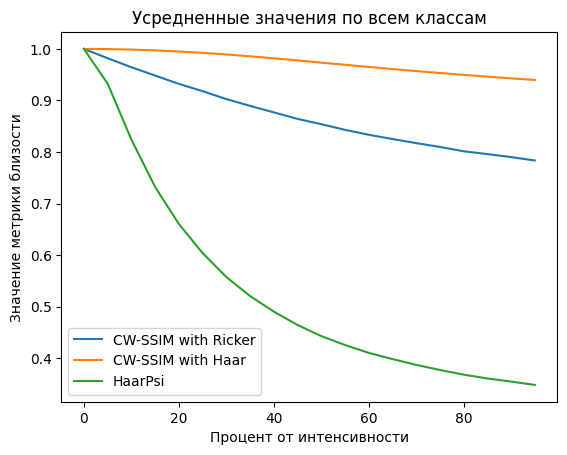

In [67]:
plt.plot(x, m_r, label='CW-SSIM with Ricker')
plt.plot(x, m_h, label='CW-SSIM with Haar')
plt.plot(x, m_p, label='HaarPsi')
plt.xlabel('Процент от интенсивности')
plt.ylabel('Значение метрики близости')
plt.title('Усредненные значения по всем классам')
plt.legend()
plt.show()

### Поворот изображения

In [71]:
from tensorflow.keras.preprocessing.image import apply_affine_transform

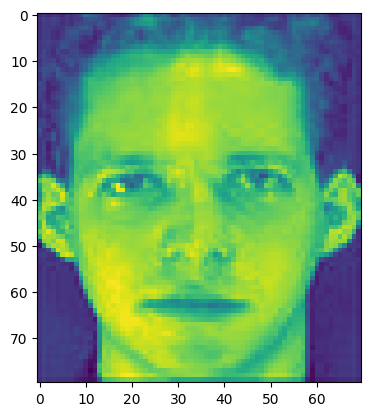

In [45]:
plt.imshow(np.resize(train.image[0],(80, 70)))

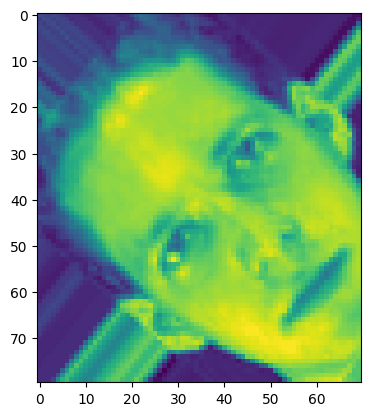

In [54]:
transformation = apply_affine_transform(
    np.array([np.resize(train.image[0],(80, 70))]),
    theta=45,
    shear=10
)
plt.imshow(transformation[0])

In [22]:
def check_aphine_distortion(data, label, degrees = [5*i for i in range(72)], label_name=None):
    y_cw_ricker = []
    y_cw_haar = []
    y_haar_psi = []
    
    sample = data.loc[data.label == label]
    sample.sort_values('number', inplace=True)
    sample.reset_index(drop=True, inplace=True)
    
    x = degrees
    
    image0 = sample.image[0]

    for i in range(len(degrees)):
        image = apply_affine_transform(
                np.array([np.resize(image0,(80, 70))]),
                theta=degrees[i]
            )
        
        cw_ricker1, cw_ricker2 = get_signal(image0.flatten(), image.flatten())
        y_cw_ricker.append(cw_ssim(cw_ricker1, cw_ricker2))

        cw_haar1, cw_haar2 = haar_signal(image0, image)
        y_cw_haar.append(cw_ssim(cw_haar1, cw_haar2))

        y_haar_psi.append(haar_psi(np.resize(image0, (80, 70)), 
                                    np.resize(image, (80, 70)))[0])
    
    #plt.imshow(np.resize(image0, (80, 70)))
    #plt.show()
    
    #if label_name:
    #    plt.title(f'Класс №{label}: {label_name}')
    #else:
    #    plt.title(f'Класс №{label}')
        
    #plt.plot(x, y_cw_ricker, label='CW-SSIM with Ricker')
    #plt.plot(x, y_haar_psi, label='HaarPsi')
    #plt.plot(x, y_cw_haar, label='CW-SSIM with Haar')
    #plt.xlabel('Градус поворота')
    #plt.ylabel('Значение метрики близости')
    #plt.legend()
    #plt.show()
    
    return y_cw_ricker, y_cw_haar, y_haar_psi

In [23]:
rot_cw_r = []
rot_cw_h = []
rot_h_p = []

for j in range(1, 41):
    r, h, p = check_aphine_distortion(train, j)
    rot_cw_r.append(r)
    rot_cw_h.append(h)
    rot_h_p.append(p)

/tmp/ipykernel_34/2763527421.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.sort_values('number', inplace=True)


NameError: name 'apply_affine_transform' is not defined

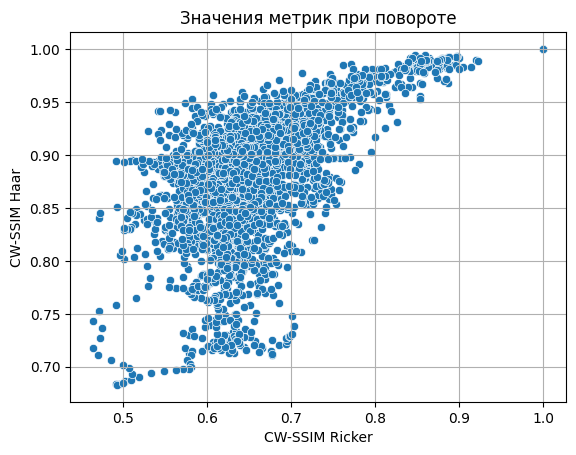

In [75]:
sns.scatterplot(x=np.array(rot_cw_r).flatten(), y=np.array(rot_cw_h).flatten())
plt.title('Значения метрик при повороте')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('CW-SSIM Haar')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

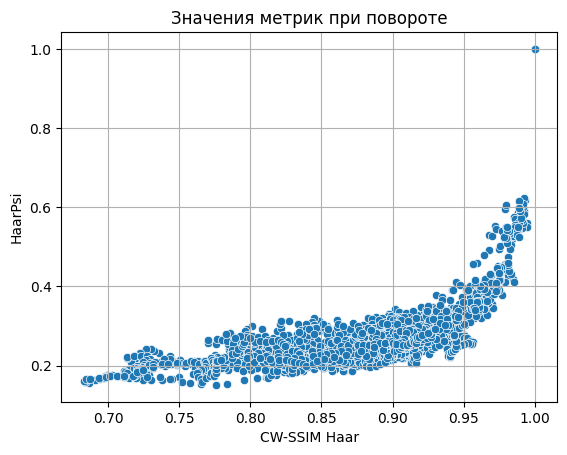

In [76]:
sns.scatterplot(x=np.array(rot_cw_h).flatten(), y=np.array(rot_h_p).flatten())
plt.title('Значения метрик при повороте')
plt.xlabel('CW-SSIM Haar')
plt.ylabel('HaarPsi')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

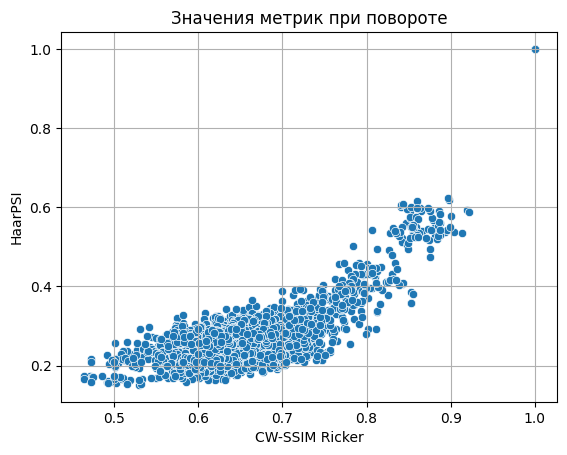

In [74]:
sns.scatterplot(x=np.array(rot_cw_r).flatten(), y=np.array(rot_h_p).flatten())
plt.title('Значения метрик при повороте')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('HaarPSI')
plt.grid(True)
#x = np.linspace(min(cw_r), max(cw_h))
#y = x
#plt.plot(x, y, color='red')
plt.show()

### Сдвиг изображения

In [ ]:
def check_aphine_distortion2(data, label, shear = [i for i in range(50)], label_name=None):
    y_cw_ricker = []
    y_cw_haar = []
    y_haar_psi = []
    
    sample = data.loc[data.label == label]
    sample.sort_values('number', inplace=True)
    sample.reset_index(drop=True, inplace=True)
    
    x = shear
    
    image0 = sample.image[0]

    for i in range(len(shear)):
        image = apply_affine_transform(
                np.array([np.resize(image0,(80, 70))]),
                shear=shear[i]
            )
        
        cw_ricker1, cw_ricker2 = get_signal(image0.flatten(), image.flatten())
        y_cw_ricker.append(cw_ssim(cw_ricker1, cw_ricker2))

        cw_haar1, cw_haar2 = haar_signal(image0, image)
        y_cw_haar.append(cw_ssim(cw_haar1, cw_haar2))

        y_haar_psi.append(haar_psi(np.resize(image0, (80, 70)), 
                                    np.resize(image, (80, 70)))[0])
    
    #plt.imshow(np.resize(image0, (80, 70)))
    #plt.show()
    
    #if label_name:
    #    plt.title(f'Класс №{label}: {label_name}')
    #else:
    #    plt.title(f'Класс №{label}')
        
    #plt.plot(x, y_cw_ricker, label='CW-SSIM with Ricker')
    #plt.plot(x, y_haar_psi, label='HaarPsi')
    #plt.plot(x, y_cw_haar, label='CW-SSIM with Haar')
    #plt.xlabel('Сдвиг')
    #plt.ylabel('Значение метрики близости')
    #plt.legend()
    #plt.show()
    
    return y_cw_ricker, y_cw_haar, y_haar_psi

In [ ]:
move_cw_r = []
move_cw_h = []
move_h_p = []

for j in range(1, 41):
    r, h, p = check_aphine_distortion2(train, j)
    move_cw_r.append(r)
    move_cw_h.append(h)
    move_h_p.append(p)

In [85]:
mean_move_r = np.zeros(50)
mean_move_h = np.zeros(50)
mean_move_p = np.zeros(50)

for i in range(len(move_cw_r)):
    mean_move_r += move_cw_r[i]
    mean_move_h += move_cw_h[i]
    mean_move_p += move_h_p[i]

In [86]:
mean_move_r = mean_move_r / 40
mean_move_h = mean_move_h / 40
mean_move_p = mean_move_p / 40

In [87]:
x1 = [i for i in range(50)]

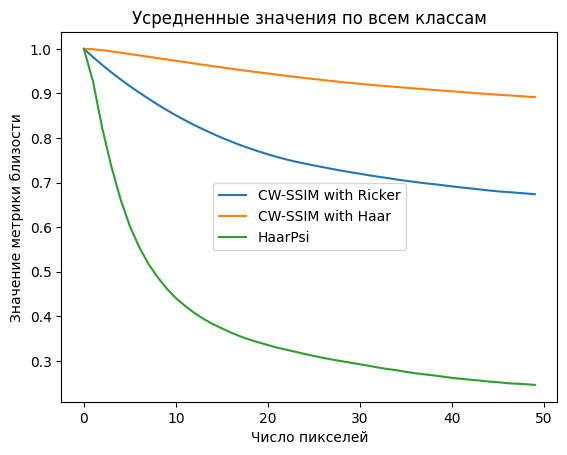

In [89]:
plt.plot(x1, mean_move_r, label='CW-SSIM with Ricker')
plt.plot(x1, mean_move_h, label='CW-SSIM with Haar')
plt.plot(x1, mean_move_p, label='HaarPsi')
plt.xlabel('Число пикселей')
plt.ylabel('Значение метрики близости')
plt.title('Усредненные значения по всем классам')
plt.legend()
plt.show()

In [19]:
sample_1_4 = train.loc[train['label'].isin([i for i in range(20)])]

In [20]:
sample_1_4.reset_index(inplace=True)

In [21]:
def smaller_graph(matrix, thresh):
    
    sim_m = np.zeros(matrix.shape)
    
    #G = nx.Graph(matrix, nodetype=int)
    
    #comp_numb = nx.number_connected_components(G)
    
    for i in range(matrix.shape[0]):
        
        for j in range(i, matrix.shape[1]):
            
            if matrix[i][j] > thresh:
            
                sim_m[i][j], sim_m[j][i] = matrix[i][j], matrix[j][i]
                
                #if nx.number_connected_components(nx.Graph(sim, nodetype=int)) != comp_numb:
                    
                #    sim_m[i][j], sim_m[i][j] = matrix[i][j], matrix[j][i]
            
    return sim_m

In [22]:
cw_matr_1_4 = sim_matrix_cw(sample_1_4.image, len(sample_1_4.image))

100%|██████████| 191/191 [00:29<00:00,  6.45it/s]


In [23]:
resize_sample_1_4 = resize_for_haar_psi(sample_1_4.image)

In [24]:
haar_matr_1_4 = sim_matrix_haar_psi(resize_sample_1_4, len(resize_sample_1_4))

100%|██████████| 190/190 [01:06<00:00,  2.85it/s]


In [25]:
cw_haar_1_4 = matrix_cw_haar(sample_1_4.image, len(sample_1_4.image))

100%|██████████| 191/191 [00:12<00:00, 15.04it/s]


In [26]:
thresh = [i * 0.005 for i in range(100)]

In [39]:
spectral_cw_res_1_4 = []
spectral_haar_res_1_4 = []
spectral_cw_haar_1_4 = []

for t in tqdm(thresh):
    small_cw_m = smaller_graph(cw_matr_1_4, t)
    
    cw_classes = spectral_clustering(small_cw_m, n_clusters=20)
    spectral_cw_res_1_4.append(adjusted_rand_score(sample_1_4.label, cw_classes))
    
    small_haar_m = smaller_graph(haar_matr_1_4, t)
    
    haar_classes = spectral_clustering(small_haar_m, n_clusters=20)
    spectral_haar_res_1_4.append(adjusted_rand_score(sample_1_4.label, haar_classes))
    
    small_cw_haar = smaller_graph(cw_haar_1_4, t)
    
    cw_haar_classes = spectral_clustering(small_cw_haar, n_clusters=20)
    spectral_cw_haar_1_4.append(adjusted_rand_score(sample_1_4.label, cw_haar_classes))

 63%|██████▎   | 63/100 [00:38<00:24,  1.52it/s]/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 64%|██████▍   | 64/100 [00:38<00:22,  1.58it/s]/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 65%|██████▌   | 65/100 [00:39<00:21,  1.64it/s]/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 66%|██████▌   | 66/100 [00:40<00:20,  1.65it/s]/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 67%|██████▋   | 67/100 [00:40<00:19,  1.65it/s]

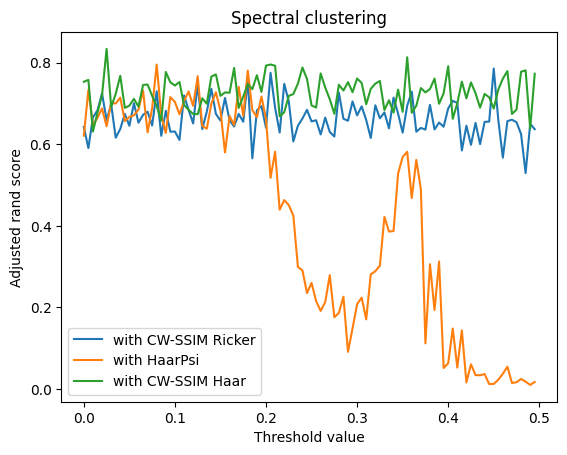

In [40]:
plt.plot(thresh, spectral_cw_res_1_4, label='with CW-SSIM Ricker')
plt.plot(thresh, spectral_haar_res_1_4, label='with HaarPsi')
plt.plot(thresh, spectral_cw_haar_1_4, label='with CW-SSIM Haar')
plt.xlabel('Threshold value')
plt.ylabel('Adjusted rand score')
plt.title('Spectral clustering')
plt.legend()
plt.show()

In [41]:
from community import community_louvain

In [42]:
louvain_cw_res_1_4 = []
louvain_haar_res_1_4 = []
louvain_cw_haar_1_4 = []

for t in tqdm(thresh):
    small_cw_m = smaller_graph(cw_matr_1_4, t)
    
    G_cw = nx.Graph(small_cw_m)
    
    cw_classes_louv = community_louvain.best_partition(G_cw)
    louvain_cw_res_1_4.append(adjusted_rand_score(sample_1_4.label, list(cw_classes_louv.values())))
    
    small_haar_m = smaller_graph(haar_matr_1_4, t)
    
    G_haar = nx.Graph(small_haar_m)
    
    haar_classes_louv = community_louvain.best_partition(G_haar)
    louvain_haar_res_1_4.append(adjusted_rand_score(sample_1_4.label, list(haar_classes_louv.values())))
    
    small_cw_haar = smaller_graph(cw_haar_1_4, t)
    
    G_cw_haar = nx.Graph(small_cw_haar)
    
    cw_haar_classes_lv = community_louvain.best_partition(G_cw_haar)
    louvain_cw_haar_1_4.append(adjusted_rand_score(sample_1_4.label, list(cw_haar_classes_lv.values())))

100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


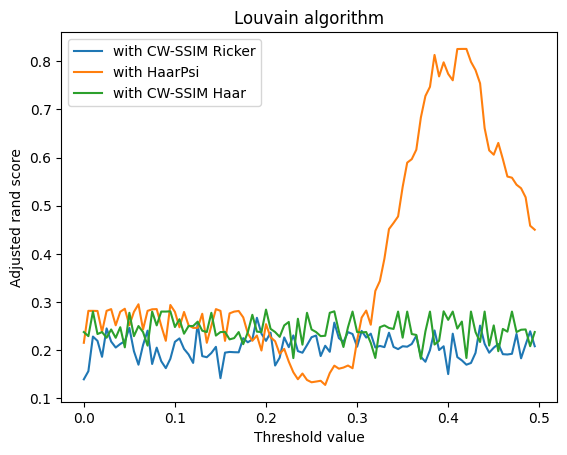

In [43]:
plt.plot(thresh, louvain_cw_res_1_4, label='with CW-SSIM Ricker')
plt.plot(thresh, louvain_haar_res_1_4, label='with HaarPsi')
plt.plot(thresh, louvain_cw_haar_1_4, label='with CW-SSIM Haar')
plt.xlabel('Threshold value')
plt.ylabel('Adjusted rand score')
plt.title('Louvain algorithm')
plt.legend()
plt.show()

In [18]:
from sklearn.cluster import DBSCAN

In [86]:
eps = 0.3
samp = 2

In [92]:
dbscan_cw_res_1_4 = []
dbscan_haar_res_1_4 = []
dbscan_cw_haar_1_4 = []

for t in tqdm(thresh):
    small_cw_m = smaller_graph(cw_matr_1_4, t)
    
    cw_classes_dbscan = DBSCAN(eps=0.4, min_samples=2).fit(small_cw_m)
    dbscan_cw_res_1_4.append(adjusted_rand_score(sample_1_4.label, cw_classes_dbscan.labels_))
    
    small_haar_m = smaller_graph(haar_matr_1_4, t)
    
    haar_classes_dbscan = DBSCAN(eps=0.9, min_samples=2).fit(small_haar_m)
    dbscan_haar_res_1_4.append(adjusted_rand_score(sample_1_4.label, haar_classes_dbscan.labels_)) 
    
    small_cw_haar = smaller_graph(cw_haar_1_4, t)
    
    cw_haar_classes_dbscan = DBSCAN(eps=0.3, min_samples=2).fit(small_cw_haar)
    dbscan_cw_haar_1_4.append(adjusted_rand_score(sample_1_4.label, cw_haar_classes_dbscan.labels_))

100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


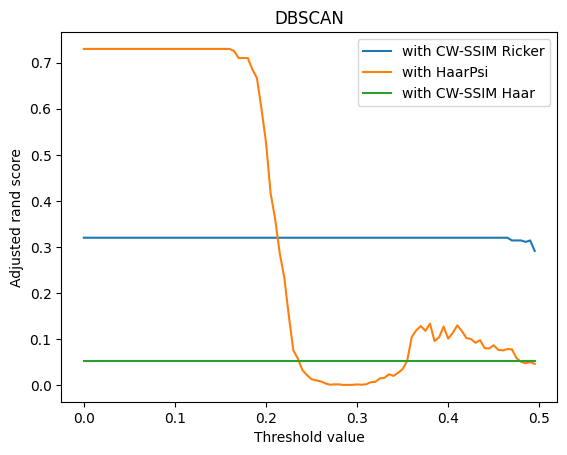

In [93]:
plt.plot(thresh, dbscan_cw_res_1_4, label='with CW-SSIM Ricker')
plt.plot(thresh, dbscan_haar_res_1_4, label='with HaarPsi')
plt.plot(thresh, dbscan_cw_haar_1_4, label='with CW-SSIM Haar')
plt.xlabel('Threshold value')
plt.ylabel('Adjusted rand score')
plt.title("DBSCAN")
plt.legend()
plt.show()

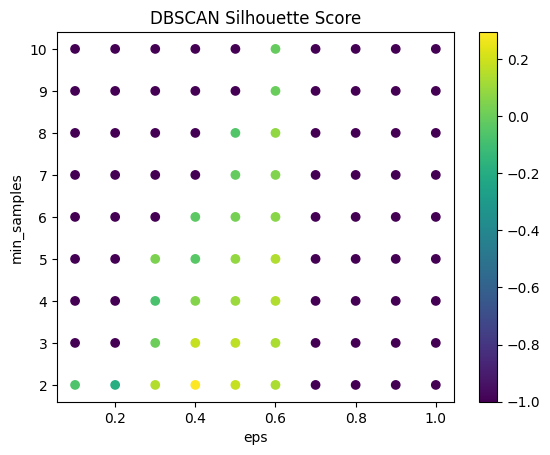

In [91]:
from sklearn.metrics import silhouette_score

eps_values = [i / 10 for i in range(1, 11)]
min_samples_values = [i for i in range(2, 11)]

# Создание пустого списка для хранения результатов
results = []

# Цикл по всем комбинациям значений eps и min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Обучение модели DBSCAN на текущих значениях eps и min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(cw_matr_1_4)

        # Вычисление Silhouette score
        labels = dbscan.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            silhouette_avg = silhouette_score(cw_matr_1_4, labels)
        else:
            silhouette_avg = -1

        # Добавление результатов в список
        results.append([eps, min_samples, silhouette_avg])

# Преобразование списка результатов в массив NumPy
results = np.array(results)

# Разделение результатов на списки значений eps, min_samples и Silhouette score
eps_list = results[:, 0]
min_samples_list = results[:, 1]
silhouette_score_list = results[:, 2]

# Построение графика кривой Silhouette
plt.figure()
plt.scatter(eps_list, min_samples_list, c=silhouette_score_list, cmap='viridis')
plt.colorbar()
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.title('DBSCAN Silhouette Score')
plt.show()